## References: 
+ https://www.pybloggers.com/2018/10/repeated-measures-anova-in-python-using-statsmodels/
+ https://pingouin-stats.org/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
import os

### Preliminaries

In [41]:
## Grab data.
behav_path = os.getcwd() + '/ProcessedData/Feedback_Processed_CombinedBehavioralEyetrackingData.csv'
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data = behav_data.fillna(0)

In [42]:
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,TotalLookingTime,Entropy
0,23,1,1,1,6,8,2,5,7,3,...,0.000000,0.000000,0.236364,0.000000,0.649351,0.000000,0.000000,0.020779,1.540,0.767231
1,23,2,1,2,5,7,1,4,8,3,...,0.000000,0.005051,0.702020,0.000000,0.017677,0.237374,0.000000,0.030303,1.584,0.324678
2,23,3,1,3,4,7,2,5,9,1,...,0.101810,0.000000,0.000000,0.000000,0.472851,0.000000,0.425339,0.000000,1.768,0.534086
3,23,4,1,1,4,7,2,5,8,3,...,0.000000,0.000000,0.088154,0.000000,0.000000,0.658402,0.000000,0.027548,1.452,0.751248
4,23,5,1,1,6,8,2,4,7,3,...,0.000000,0.361582,0.000000,0.000000,0.322034,0.000000,0.000000,0.014124,1.416,0.996135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,71,396,20,1,5,7,3,4,9,2,...,0.000000,0.031339,0.000000,0.000000,0.287749,0.000000,0.641026,0.025641,1.404,0.000000
13596,71,397,20,1,5,8,2,4,9,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.890173,0.078035,1.384,0.194061
13597,71,398,20,1,6,7,2,4,9,3,...,0.432990,0.000000,0.067010,0.000000,0.000000,0.286082,0.152062,0.061856,1.552,0.260696
13598,71,399,20,1,6,7,3,5,8,2,...,0.000000,0.000000,0.000000,0.086514,0.837150,0.000000,0.000000,0.043257,1.572,0.000000


### 1. Visualize RT

For illustration, we look at how trial within game (**WithinGameTrial**) and age group (**AgeGroup**) affect **Entropy**.

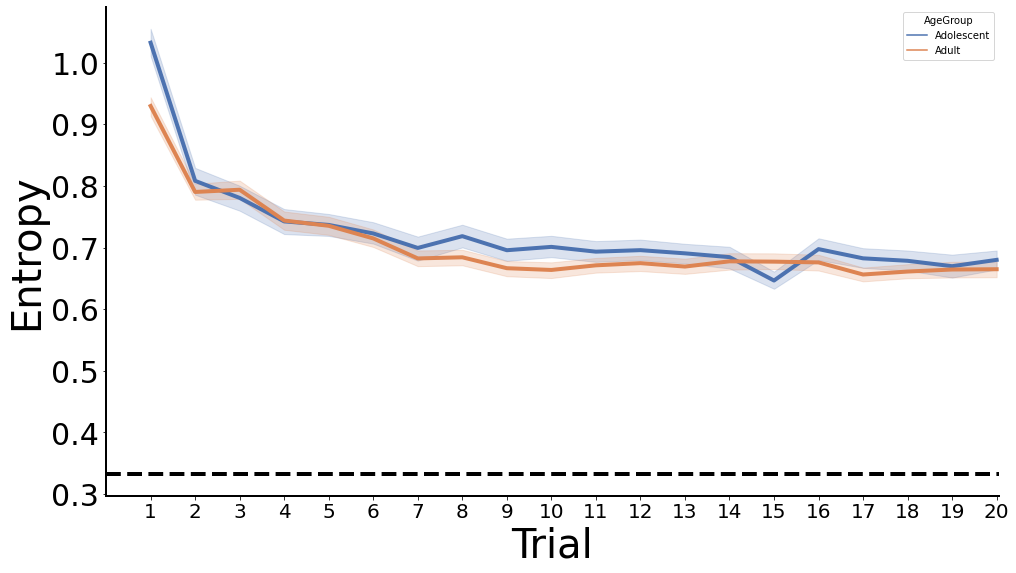

In [49]:
# This line groups by relevant variables (aka factors). 
df = pd.melt(behav_data, col_level=0, id_vars=['Subj','WithinGameTrial','Entropy', 'AgeGroup'], value_vars=['RT']).dropna()

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = "WithinGameTrial", y="value", hue='AgeGroup', err_style="band", ci=68, data=df, lw=4, palette='deep')
sns.despine()
ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,0.8])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

Based on the above plot, we would expect a significant effect of both age group and trial.

### 2. Reformat data for 2-way repeated-measures ANOVA

We're first going to run a 2-way repeated measures ANOVA in which both factors of interest are *within-subject*. The "melt" command above also reformatted the data to the way that the ANOVA function expects it. 
Let's have a look:

In [50]:
df.head(10)

,Subj,WithinGameTrial,Entropy,AgeGroup,variable,value
0,23,1,0.767231,Adolescent,RT,1.12700
1,23,2,0.324678,Adolescent,RT,1.08580
2,23,3,0.534086,Adolescent,RT,1.24420
3,23,4,0.751248,Adolescent,RT,0.47509
4,23,5,0.996135,Adolescent,RT,0.88090
5,23,6,0.525721,Adolescent,RT,1.26340
6,23,7,0.332279,Adolescent,RT,0.52625
7,23,8,0.896607,Adolescent,RT,0.42968
8,23,9,0.232524,Adolescent,RT,0.92338
9,23,10,0.611740,Adolescent,RT,0.55373


The dependent variable is **RT**, and it's coded in the **value** column. The factors we are interested in are **WithinGameTrial** (within-subject) and **Entropy** (also within-subject). The **Subj** column is considered the "random effect." We can run a repeated-measures ANOVA using the *statsmethods* package like so: 

In [51]:
print(AnovaRM(data=df, depvar='value', subject='Subj', within=['WithinGameTrial', 'Entropy'], aggregate_func='mean').fit())

ValueError: Data is unbalanced.

### 3. Run mixed 2-way ANOVA.

For LDM, we need a mixed ANOVA in which one of the factors (**Age**) is between-subjects. Just for illustration, let's add a fake between-subjects age column to our dataframe. 

Then we can run the model using the *pingouin* package: 

In [48]:
aov = pg.mixed_anova(data=df, dv='value', between='AgeGroup', within='WithinGameTrial',
                     subject='Subj', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2     MS      F    p-unc    np2      eps
---------------  -----  -----  -----  -----  -----  -------  -----  -------
AgeGroup         0.109      1     32  0.109  1.281    0.266  0.038  nan
WithinGameTrial  0.488     19    608  0.026  8.370    0.000  0.207    0.594
Interaction      0.059     19    608  0.003  1.014    0.442  0.031  nan

